# Fokker-Planck Equation: 2D Integration

This notebook goes over an exploration of the instantiation of a 2-dimensional integrator, as well as how the use of dense vs. sparse matrices impacts performance in terms of initialization. Next, we look at visualizing the actual diffusion matrices that are initialized, and how they change under different boundary conditions

In [1]:
import os
import numpy as np
import pandas as pd
import scipy.sparse as sp
from scipy.sparse.linalg import inv
import matplotlib.pyplot as plt
import seaborn as sns
import timeit
sns.set(style='darkgrid', palette='hls')

from FPE.integrator_2D import FPE_integrator_2D
from FPE.Integrator import FPE_Integrator_1D

%load_ext autoreload
%autoreload 2

In [2]:
D = 1.0
dx = 0.1
dy = 0.1
dt = 0.01
x_array = np.arange(-1, 1, dx)
y_array = np.arange(-1, 1, dy)


# Example of matrix initialization using Sparse Matrices
def initDiffusionSparse(D, dt, dx, dy, N, Nx, Ny):

    expImp = 0.5
    alpha = D * dt / (dx * dy)

    AMat = sp.lil_matrix((N, N))
    BMat = sp.lil_matrix((N, N))

    # Bulk term initializations
    AMat.setdiag(1 + 4 * alpha * expImp)
    AMat.setdiag(-1 * expImp * alpha, k=1)
    AMat.setdiag(-1 * expImp * alpha, k=-1)
    AMat.setdiag(-1 * expImp * alpha, k=Nx)
    AMat.setdiag(-1 * expImp * alpha, k=-Nx)

    BMat.setdiag(1 - 4 * alpha * (1 - expImp))
    BMat.setdiag(alpha * (1 - expImp), k=1)
    BMat.setdiag(alpha * (1 - expImp), k=-1)
    BMat.setdiag(alpha * (1 - expImp), k=Nx)
    BMat.setdiag(alpha * (1 - expImp), k=-Nx)

    # convert to csr format
    AMat = AMat.tocsc()
    BMat = BMat.tocsc()

    CMat = inv(AMat).dot(BMat)

    return AMat, BMat, CMat

# And the dense matrix version
def initDiffusionNumpy(D, dt, dx, dy, N, Nx, Ny):
    alpha = D * dt / (dx * dy)
    expImp = 0.5

    AMat = np.zeros((N, N))
    BMat = np.zeros((N, N))

    # Bulk term initializations
    AMat = (
        np.diag(1 + 4 * alpha * expImp * np.ones(N))
        - np.diag(expImp * alpha * np.ones(N - 1), k=1)
        - np.diag(expImp * alpha * np.ones(N - 1), k=-1)
        # far off-diagonal terms representing y-transitions
        - np.diag(expImp * alpha * np.ones(N - Nx), k=Nx)
        - np.diag(expImp * alpha * np.ones(N - Nx), k=-Nx)
    )

    BMat = (
        np.diag(1 - 4 * alpha * (1 - expImp) * np.ones(N))
        + np.diag(alpha * (1 - expImp) * np.ones(N - 1), k=1)
        + np.diag(alpha * (1 - expImp) * np.ones(N - 1), k=-1)
        + np.diag(alpha * (1 - expImp) * np.ones(N - Nx), k=Nx)
        + np.diag(alpha * (1 - expImp) * np.ones(N - Nx), k=-Nx)
    )

    CMat = np.matmul(np.linalg.inv(AMat), BMat)
    return AMat, BMat, CMat

# mimic constructor
def test_constructor(
    D, dt, dx, dy, x_array, y_array, is_sparse
):

    Nx = len(x_array)
    Ny = len(y_array)
    N = Nx * Ny

    if is_sparse:
        initDiffusionSparse(D, dt, dx, dy, N, Nx, Ny)
    else:
        initDiffusionNumpy(D, dt, dx, dy, N, Nx, Ny)


In [4]:
dx_arr = [0.2, 0.1, 0.075, 0.05, 0.025]
time_arr_numpy = []

for dx in dx_arr:
    x_array = np.arange(-1, 1, dx)
    y_array = np.arange(-1, 1, dx)

    exec_time = timeit.timeit(lambda: test_constructor(D, dt, dx, dx, x_array, y_array, False), number=3)
    time_arr_numpy.append(exec_time)
    print(f"execution time: {exec_time} seconds for dx={dx}")


execution time: 0.003830874979030341 seconds for dx=0.2
execution time: 0.037155792000703514 seconds for dx=0.1
execution time: 0.13336070801597089 seconds for dx=0.075
execution time: 0.9144950829795562 seconds for dx=0.05
execution time: 51.46553037496051 seconds for dx=0.025


In [5]:

time_arr_sparse = []

for dx in dx_arr:
    x_array = np.arange(-1, 1, dx)
    y_array = np.arange(-1, 1, dx)

    exec_time = timeit.timeit(lambda: test_constructor(D, dt, dx, dx, x_array, y_array, True), number=3)
    time_arr_sparse.append(exec_time)
    print(f"execution time: {exec_time} seconds for dx={dx}")

execution time: 0.05293754203012213 seconds for dx=0.2
execution time: 0.20499050000216812 seconds for dx=0.1
execution time: 0.41376687498996034 seconds for dx=0.075
execution time: 1.3176538749830797 seconds for dx=0.05
execution time: 18.887234708003234 seconds for dx=0.025


In [6]:
# Here, we focus in on the 0.05 -> 0.025 regime
dx_arr = [0.05, 0.045, 0.04, 0.035, 0.03, 0.025, 0.02]
time_arr_numpy_alt = []

for dx in dx_arr:
    x_array = np.arange(-1, 1, dx)
    y_array = np.arange(-1, 1, dx)

    exec_time = timeit.timeit(lambda: test_constructor(D, dt, dx, dx, x_array, y_array, False), number=3)
    time_arr_numpy_alt.append(exec_time)
    print(f"execution time: {exec_time} seconds for dx={dx}")

execution time: 0.8652481670142151 seconds for dx=0.05
execution time: 1.7654814170091413 seconds for dx=0.045
execution time: 3.305103499966208 seconds for dx=0.04
execution time: 7.8906683750101365 seconds for dx=0.035
execution time: 19.586765374988317 seconds for dx=0.03
execution time: 57.0523150000372 seconds for dx=0.025
execution time: 238.64169204095379 seconds for dx=0.02


In [7]:
dx_arr = [0.05, 0.045, 0.04, 0.035, 0.03, 0.025, 0.02]
time_arr_sparse_alt = []

for dx in dx_arr:
    x_array = np.arange(-1, 1, dx)
    y_array = np.arange(-1, 1, dx)

    exec_time = timeit.timeit(lambda: test_constructor(D, dt, dx, dx, x_array, y_array, True), number=3)
    time_arr_sparse_alt.append(exec_time)
    print(f"execution time: {exec_time} seconds for dx={dx}")

execution time: 1.5834112499724142 seconds for dx=0.05
execution time: 2.3092826250358485 seconds for dx=0.045
execution time: 3.287824459024705 seconds for dx=0.04
execution time: 5.655001832987182 seconds for dx=0.035
execution time: 9.216141166980378 seconds for dx=0.03
execution time: 19.350663209042978 seconds for dx=0.025
execution time: 50.684410249989014 seconds for dx=0.02


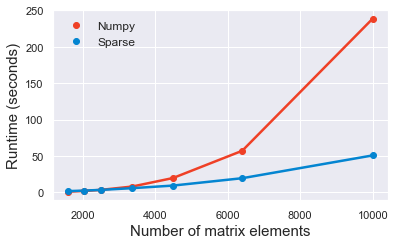

In [8]:
fig, ax = plt.subplots(1, 1, figsize=(6, 3.5))

n_arr = []
for dx in dx_arr:
    x_array = np.arange(-1, 1, dx)
    n_arr.append(len(x_array) ** 2)

ax.plot(n_arr, time_arr_numpy_alt, linewidth=2.5, color=sns.xkcd_rgb["tomato"])
ax.plot(n_arr, time_arr_sparse_alt, linewidth=2.5, color=sns.xkcd_rgb["cerulean"])

ax.plot(n_arr, time_arr_numpy_alt, 'o', markersize=6, color=sns.xkcd_rgb["tomato"], label="Numpy")
ax.plot(n_arr, time_arr_sparse_alt, 'o', markersize=6, color=sns.xkcd_rgb["cerulean"], label="Sparse")

ax.set_xlabel(r"Number of matrix elements", fontsize=15)
ax.set_ylabel(r"Runtime (seconds)", fontsize=15)

ax.legend(fontsize=12, frameon=False)


In [3]:
# Finally, we want to actually check that the two routines are producing the same output
dx = 0.05
x_array = np.arange(-1, 1, dx)
Nx = len(x_array)
N = Nx * Nx

A_np, B_np, C_np = initDiffusionNumpy(D, dt, dx, dx, N, Nx, Nx)
A_sp, B_sp, C_sp = initDiffusionSparse(D, dt, dx, dx, N, Nx, Nx)


In [4]:
# Convert the scipy back into dense format

np.all(np.isclose((A_sp.toarray() - A_np), 0)), np.all(np.isclose((B_sp.toarray() - B_np), 0)), np.all(np.isclose((C_sp.toarray() - C_np), 0))

(True, True, True)

In [5]:
# So, it looks like this works, and given that we will primarily be working
# with large arrays, we can default to the sparse matrix initialization methods

In [6]:
# Now we can test the BC initializations, and the actual initialization of a 2D
# integrator object. For this, we will use a small set of coordiantes. it will
# be a 4x4 grid

x_array = np.linspace(0, 1, 4)
dx = 1.0
dt = 0.5
D = 2.0

fpe_2d_open = FPE_integrator_2D(D, dt, dx, dx, x_array, x_array, boundaryCond='open')
fpe_1d_open = FPE_Integrator_1D(D, dt, dx, x_array, boundaryCond="open")

fpe_2d_peri = FPE_integrator_2D(D, dt, dx, dx, x_array, x_array, boundaryCond='periodic')
fpe_1d_peri = FPE_Integrator_1D(D, dt, dx, x_array, boundaryCond="periodic")

fpe_2d_hard = FPE_integrator_2D(D, dt, dx, dx, x_array, x_array, boundaryCond='hard-wall')
fpe_1d_hard = FPE_Integrator_1D(D, dt, dx, x_array, boundaryCond="hard-wall")

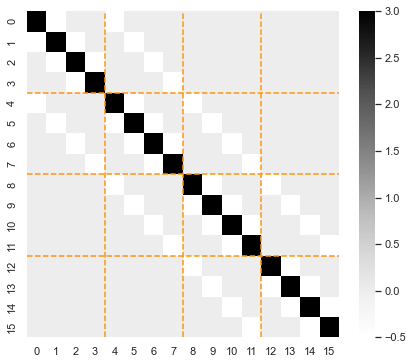

In [7]:
fig, ax = plt.subplots(1, 1, figsize=(7, 6))
sns.heatmap(fpe_2d_open.AMat.toarray(), cmap="Greys", ax=ax)

ax.axhline(4, linestyle='--', color=sns.xkcd_rgb["tangerine"])
ax.axhline(8, linestyle='--', color=sns.xkcd_rgb["tangerine"])
ax.axhline(12, linestyle='--', color=sns.xkcd_rgb["tangerine"])
ax.axvline(4, linestyle='--', color=sns.xkcd_rgb["tangerine"])
ax.axvline(8, linestyle='--', color=sns.xkcd_rgb["tangerine"])
ax.axvline(12, linestyle='--', color=sns.xkcd_rgb["tangerine"])



<AxesSubplot:>

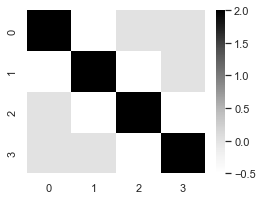

In [8]:
fig, ax = plt.subplots(1, 1, figsize=(4, 3))
sns.heatmap(fpe_1d_open.AMat, cmap="Greys")


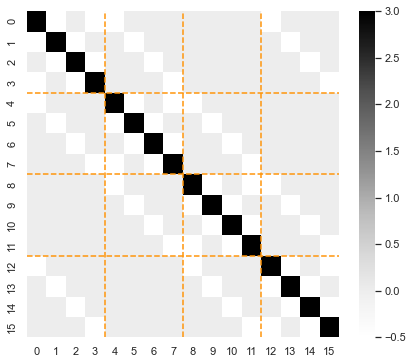

In [9]:
fig, ax = plt.subplots(1, 1, figsize=(7, 6))
sns.heatmap(fpe_2d_peri.AMat.toarray(), cmap="Greys", ax=ax)

ax.axhline(4, linestyle='--', color=sns.xkcd_rgb["tangerine"])
ax.axhline(8, linestyle='--', color=sns.xkcd_rgb["tangerine"])
ax.axhline(12, linestyle='--', color=sns.xkcd_rgb["tangerine"])
ax.axvline(4, linestyle='--', color=sns.xkcd_rgb["tangerine"])
ax.axvline(8, linestyle='--', color=sns.xkcd_rgb["tangerine"])
ax.axvline(12, linestyle='--', color=sns.xkcd_rgb["tangerine"])



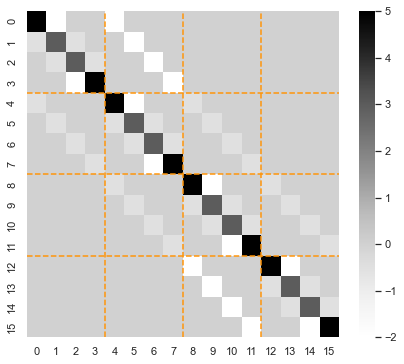

In [10]:
fig, ax = plt.subplots(1, 1, figsize=(7, 6))
sns.heatmap(fpe_2d_hard.AMat.toarray(), cmap="Greys", ax=ax)

ax.axhline(4, linestyle='--', color=sns.xkcd_rgb["tangerine"])
ax.axhline(8, linestyle='--', color=sns.xkcd_rgb["tangerine"])
ax.axhline(12, linestyle='--', color=sns.xkcd_rgb["tangerine"])
ax.axvline(4, linestyle='--', color=sns.xkcd_rgb["tangerine"])
ax.axvline(8, linestyle='--', color=sns.xkcd_rgb["tangerine"])
ax.axvline(12, linestyle='--', color=sns.xkcd_rgb["tangerine"])


In [11]:
fpe_2d_hard.AMat.toarray()

array([[ 5. , -2. ,  0. ,  0. , -2. ,  0. ,  0. ,  0. ,  0. ,  0. ,  0. ,
         0. ,  0. ,  0. ,  0. ,  0. ],
       [-0.5,  3. , -0.5,  0. ,  0. , -2. ,  0. ,  0. ,  0. ,  0. ,  0. ,
         0. ,  0. ,  0. ,  0. ,  0. ],
       [ 0. , -0.5,  3. , -0.5,  0. ,  0. , -2. ,  0. ,  0. ,  0. ,  0. ,
         0. ,  0. ,  0. ,  0. ,  0. ],
       [ 0. ,  0. , -2. ,  5. ,  0. ,  0. ,  0. , -2. ,  0. ,  0. ,  0. ,
         0. ,  0. ,  0. ,  0. ,  0. ],
       [-0.5,  0. ,  0. ,  0. ,  5. , -2. ,  0. ,  0. , -0.5,  0. ,  0. ,
         0. ,  0. ,  0. ,  0. ,  0. ],
       [ 0. , -0.5,  0. ,  0. , -0.5,  3. , -0.5,  0. ,  0. , -0.5,  0. ,
         0. ,  0. ,  0. ,  0. ,  0. ],
       [ 0. ,  0. , -0.5,  0. ,  0. , -0.5,  3. , -0.5,  0. ,  0. , -0.5,
         0. ,  0. ,  0. ,  0. ,  0. ],
       [ 0. ,  0. ,  0. , -0.5,  0. ,  0. , -2. ,  5. ,  0. ,  0. ,  0. ,
        -0.5,  0. ,  0. ,  0. ,  0. ],
       [ 0. ,  0. ,  0. ,  0. , -0.5,  0. ,  0. ,  0. ,  5. , -2. ,  0. ,
         0. , -0.5,  0